Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)


In [0]:
train = df[pd.DatetimeIndex(df['SALE_DATE']).month.isin([1,2,3])] # Train the model with Jan, Feb, March data
test = df[pd.DatetimeIndex(df['SALE_DATE']).month.isin([4])] # Test with April

In [0]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,18167.0,4.447262e+03,3.679406e+03,1.0,1343.0,3569.0,6656.0,16350.0
LOT,18167.0,3.436415e+02,6.061895e+02,1.0,21.0,49.0,286.0,9022.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,18167.0,1.078270e+04,1.121115e+03,0.0,10306.0,11210.0,11360.0,11697.0
RESIDENTIAL_UNITS,18167.0,1.721418e+00,9.381721e+00,0.0,0.0,1.0,2.0,750.0
COMMERCIAL_UNITS,18167.0,2.989486e-01,6.087744e+00,-1.0,0.0,0.0,0.0,570.0
TOTAL_UNITS,18167.0,2.172235e+00,1.166344e+01,0.0,1.0,1.0,2.0,755.0
GROSS_SQUARE_FEET,18167.0,3.214913e+03,2.155829e+04,0.0,528.0,1368.0,2273.5,1303935.0
YEAR_BUILT,18162.0,1.822193e+03,4.836412e+02,0.0,1920.0,1940.0,1965.0,2019.0
TAX_CLASS_AT_TIME_OF_SALE,18167.0,1.617053e+00,8.073494e-01,1.0,1.0,1.0,2.0,4.0


In [0]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BOROUGH,18167,5,4,5883,NaT,NaT
TAX_CLASS_AT_PRESENT,18167,10,1,8911,NaT,NaT
NEIGHBORHOOD,18167,11,OTHER,15058,NaT,NaT
BUILDING_CLASS_CATEGORY,18167,43,01 ONE FAMILY DWELLINGS,4094,NaT,NaT
SALE_DATE,18167,90,2019-01-24 00:00:00,480,2019-01-01,2019-03-31
BUILDING_CLASS_AT_PRESENT,18167,140,D4,2640,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,18167,140,D4,2640,NaT,NaT
APARTMENT_NUMBER,3972,1450,4,81,NaT,NaT
LAND_SQUARE_FEET,18139,3207,0,5784,NaT,NaT
ADDRESS,18167,17926,N/A ROCKAWAY BOULEVARD,5,NaT,NaT


In [0]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    3.200017e+06
2    5.736442e+05
3    8.495242e+05
4    7.335611e+05
5    3.947132e+05
Name: SALE_PRICE, dtype: float64

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET', 'ADDRESS', 'EASE-MENT', 'YEAR_BUILT']
#high_cardinality that works = ['TAX_CLASS_AT_PRESENT', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'SALE_DATE', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET', 'ADDRESS', 'EASE-MENT', 'YEAR_BUILT']
features = train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
X_train.head(10)

,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
0,1,0,0,0,0,716,1246,10011.0,1.0,0.0,1.0,1979.0,2007.0,2
1,1,0,0,0,0,812,68,10018.0,0.0,6.0,6.0,15435.0,1920.0,4
2,1,0,0,0,0,839,69,10018.0,0.0,7.0,7.0,11332.0,1930.0,4
3,1,0,0,0,0,592,1041,10014.0,1.0,0.0,1.0,500.0,0.0,2
4,1,0,0,0,0,1379,1402,10065.0,1.0,0.0,1.0,6406.0,0.0,2
5,1,0,0,0,0,1551,131,10128.0,10.0,0.0,10.0,6570.0,1920.0,2
6,1,0,0,0,0,1891,159,10025.0,10.0,0.0,10.0,5810.0,1900.0,2
7,0,1,0,0,0,4090,37,10461.0,1.0,0.0,1.0,1328.0,1925.0,1
8,0,1,0,0,0,4120,18,10461.0,1.0,0.0,1.0,1728.0,1935.0,1
9,0,1,0,0,0,4120,20,10461.0,1.0,0.0,1.0,1728.0,1935.0,1


In [0]:
X_test.head(10)

In [0]:
import category_encoders as cat_enc

encoder = cat_enc.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test =  encoder.transform(X_test)


In [14]:
X_train.dtypes

BOROUGH_1                      int64
BOROUGH_2                      int64
BOROUGH_3                      int64
BOROUGH_4                      int64
BOROUGH_5                      int64
BLOCK                          int64
LOT                            int64
ZIP_CODE                     float64
RESIDENTIAL_UNITS            float64
COMMERCIAL_UNITS             float64
TOTAL_UNITS                  float64
GROSS_SQUARE_FEET            float64
YEAR_BUILT                   float64
TAX_CLASS_AT_TIME_OF_SALE      int64
dtype: object

In [38]:
pd.isnull(X_test).sum() > 0

BOROUGH                      False
BLOCK                        False
LOT                          False
ZIP_CODE                     False
RESIDENTIAL_UNITS            False
COMMERCIAL_UNITS             False
TOTAL_UNITS                  False
GROSS_SQUARE_FEET            False
TAX_CLASS_AT_TIME_OF_SALE    False
dtype: bool

In [78]:
import numpy as np

X_train.replace(np.inf, np.nan)

,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_21 OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_26 OTHER HOTELS,BUILDING_CLASS_CATEGORY_45 CONDO HOTELS,BUILDING_CLASS_CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING_CLASS_CATEGORY_30 WAREHOUSES,BUILDING_CLASS_CATEGORY_46 CONDO STORE BUILDINGS,BUILDING_CLASS_CATEGORY_25 LUXURY HOTELS,BUILDING_CLASS_CATEGORY_34 THEATRES,BUILDING_CLASS_CATEGORY_37 RELIGIOUS FACILITIES,BUILDING_CLASS_CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS,BUILDING_CLASS_CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING_CLASS_CATEGORY_11A CONDO-RENTALS,BUILDING_CLASS_CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING_CLASS_CATEGORY_23 LOFT BUILDINGS,BUILDING_CLASS_CATEGORY_28 COMMERCIAL CONDOS,BUILDING_CLASS_CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING_CLASS_CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING_CLASS_CATEGORY_39 TRANSPORTATION FACILITIES,BUILDING_CLASS_CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,TAX_CLASS_AT_PRESENT_2,TAX_CLASS_AT_PRESENT_4,TAX_CLASS_AT_PRESENT_2C,TAX_CLASS_AT_PRESENT_2B,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1B,TAX_CLASS_AT_PRESENT_2A,TAX_CLASS_AT_PRESENT_1A,TAX_CLASS_AT_PRESENT_1C,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,TAX_CLASS_AT_TIME_OF_SALE
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,716,1246,10011.0,1.0,0.0,1.0,1979.0,2
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,812,68,10018.0,0.0,6.0,6.0,15435.0,4
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,839,69,10018.0,0.0,7.0,7.0,11332.0,4
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,592,1041,10014.0,1.0,0.0,1.0,500.0,2
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1379,1402,10065.0,1.0,0.0,1.0,6406.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
X_test = X_test.fillna(method='ffill')

In [0]:
# Feature Scaling

from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=8)

X_train_select = selector.fit_transform(X_train, y_train)
X_test_select = selector.transform(X_test)

In [0]:
all_names = X_train.columns

In [0]:
selected_mask = selector.get_support()

In [0]:
selected_names = all_names[selected_mask]

In [0]:
unselected_names = all_names[~selected_mask]

In [44]:
selected_names

Index(['BOROUGH', 'BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [45]:
unselected_names

Index(['LOT'], dtype='object')

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $2,095,557 

2 features
Test Mean Absolute Error: $2,050,312 

3 features
Test Mean Absolute Error: $2,048,129 

4 features
Test Mean Absolute Error: $2,044,153 

5 features
Test Mean Absolute Error: $2,022,504 

6 features
Test Mean Absolute Error: $2,030,086 

7 features
Test Mean Absolute Error: $2,019,406 

8 features
Test Mean Absolute Error: $2,020,932 

9 features
Test Mean Absolute Error: $2,020,946 

10 features
Test Mean Absolute Error: $2,065,502 

11 features
Test Mean Absolute Error: $2,066,994 

12 features
Test Mean Absolute Error: $2,077,518 

13 features
Test Mean Absolute Error: $2,077,429 

14 features
Test Mean Absolute Error: $2,092,620 

15 features
Test Mean Absolute Error: $2,090,457 

16 features
Test Mean Absolute Error: $2,088,953 

17 features
Test Mean Absolute Error: $2,083,759 

18 features
Test Mean Absolute Error: $2,083,971 

19 features
Test Mean Absolute Error: $2,084,007 

20 features
Test Mean Absolute Error: $2

In [0]:
#Ridge Regression

%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

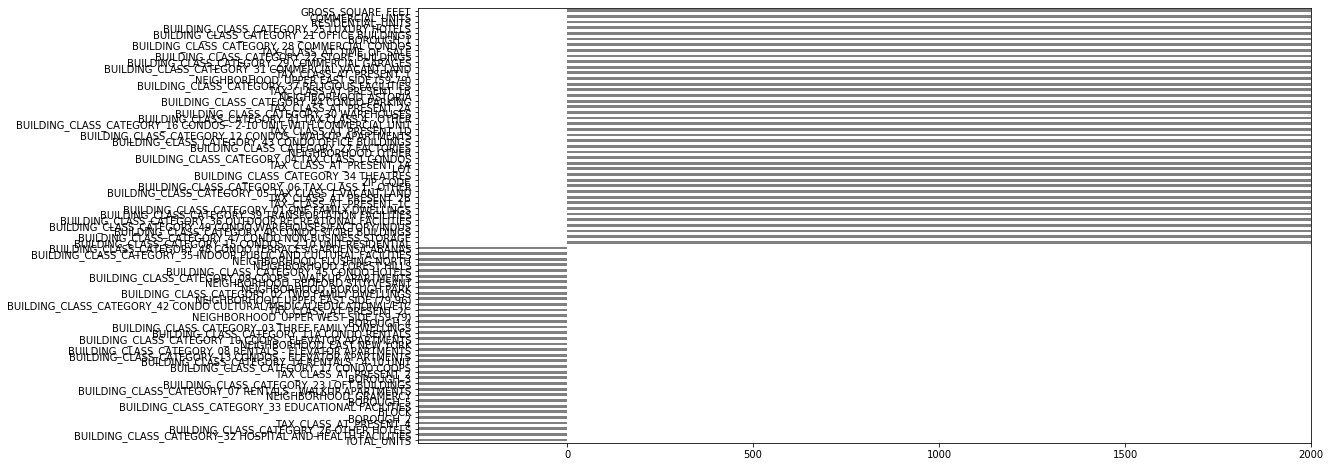

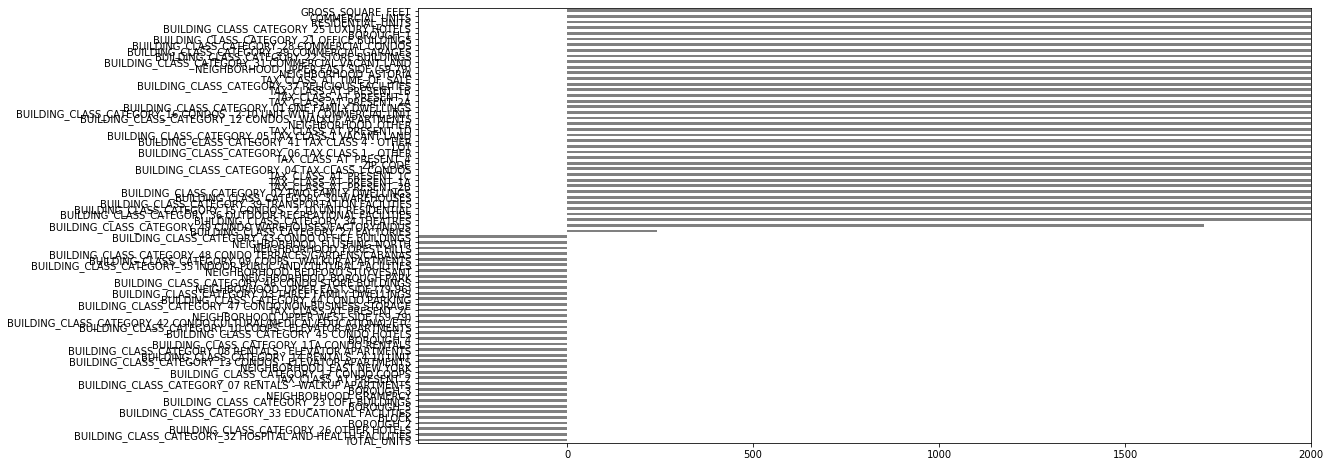

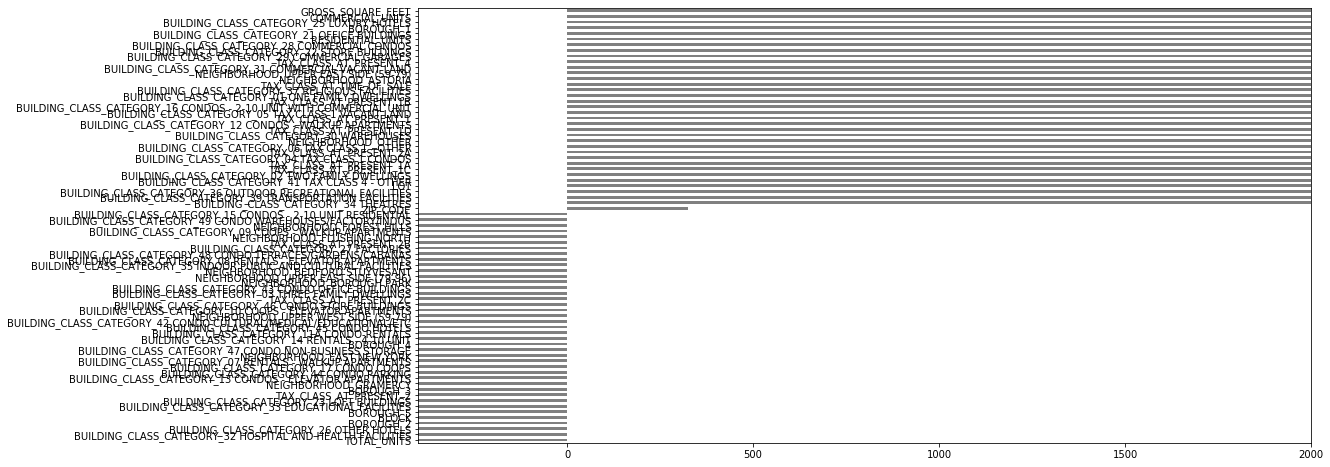

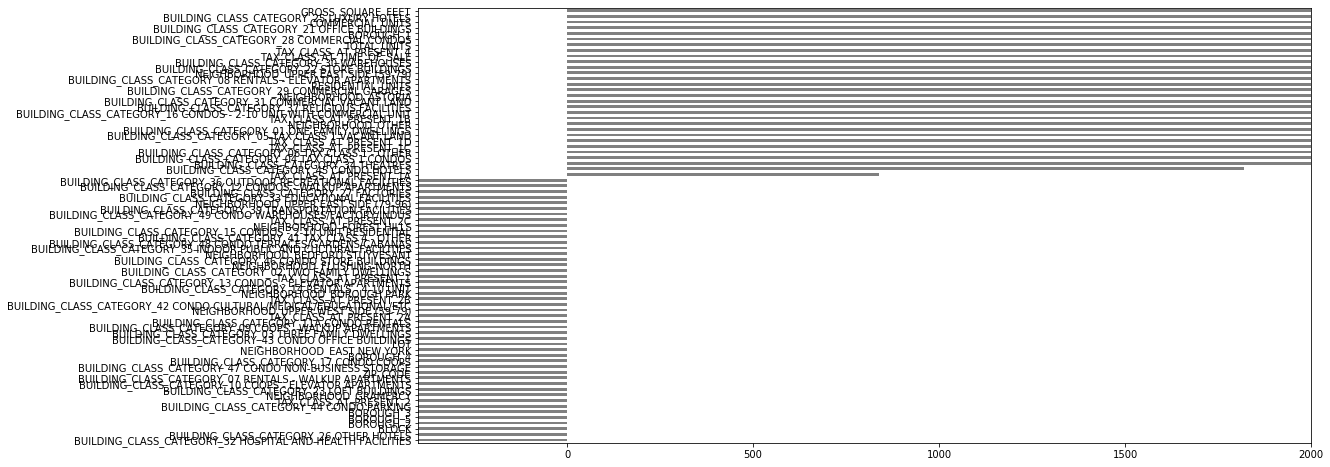

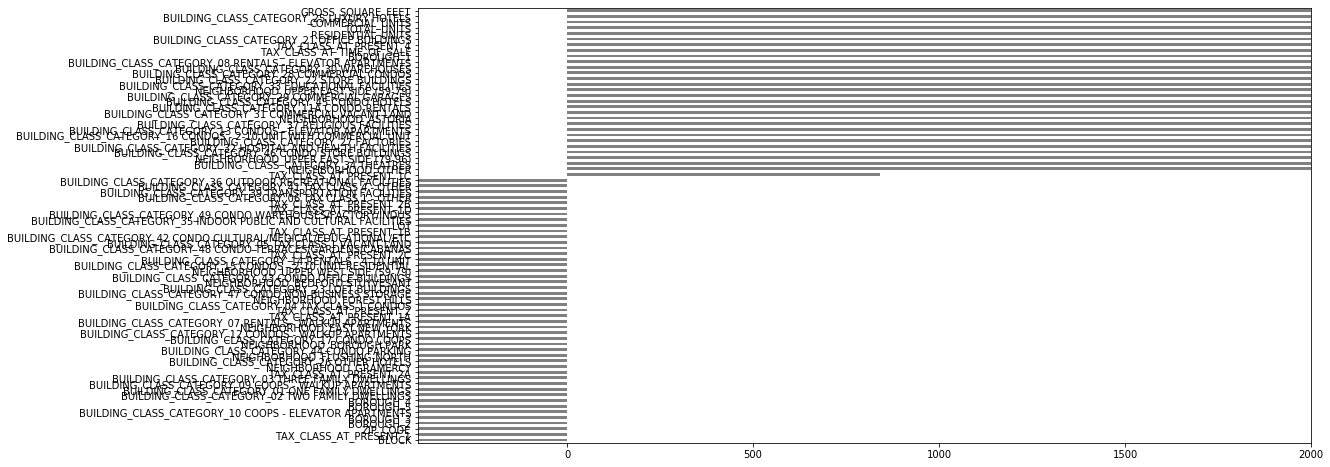

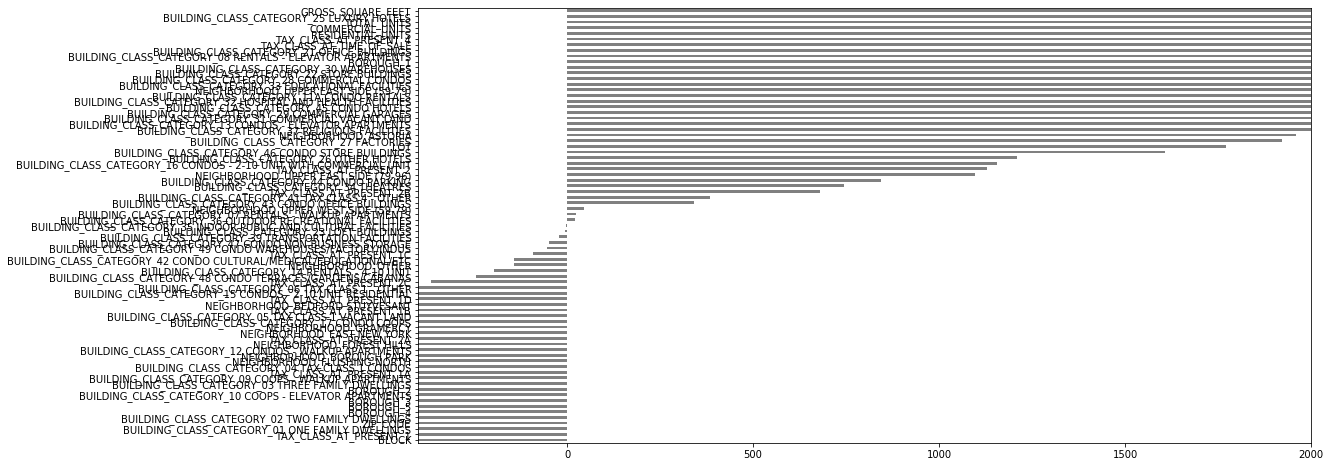

In [84]:
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)

    # Get Train MAE
    y_pred = model.predict(X_train_scaled)
    mae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${mae:,.0f}'))

    # Get Test MAE
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,2000)
    plt.show()